Ноутбук, в котором создаем train и test dataset для обучения TFR-Bert

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
! pip install tensorflow-ranking==0.3.2
! pip install tf-models-official==2.7.1

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_ranking as tfr

In [3]:
%%time
metadata_parsed = pd.read_csv('metadata_parsed_with_punctuation.csv')

Wall time: 6.42 s


In [4]:
metadata_parsed = metadata_parsed.dropna()

In [5]:
metadata_parsed.shape

(912229, 7)

In [6]:
metadata_parsed.head()

,rank,category,description,title,brand,feature,price
0,175420,Beauty & Personal Care (See Top 100 in Beauty ...,"[""These extra long backscratcher/shoehorns are...",BambooMN Brand - 1 x 25 Bamboo Backscratcher S...,BambooMN,"[""A perfect gift for a friend who could use an...",9.95
1,132516,Beauty & Personal Care (See Top 100 in Beauty ...,[],Infinity Jars 30 Ml (1 fl oz) Black Ultraviole...,Infinity Jars,"LABORATORY TESTED AND APPROVED, ULTRAVIOLET GL...",13.00
2,41845,Beauty & Personal Care (See Top 100 in Beauty ...,Bring a natural element into your bathroom or ...,InterDesign Twigz Free Standing Toilet Paper H...,InterDesign,VINTAGE LOOK: Silver finish steel wire toilet ...,24.37
3,302442,Grocery & Gourmet Food (See Top 100 in Grocery...,"["". Simply heat bottle in a hot water bath unt...",F/X Gelatin-Graftobian,Graftobian,"[""F/X Gelatin is the ''heat and serve'' of gor...",29.99
4,250013,Beauty & Personal Care (See Top 100 in Beauty ...,BOOK LOVER Street Sign books novels readers re...,SignMission Book Lover Street Sign Books Novel...,SignMission,"Sign Size: 4"" X 18""', 'Perfect Gift - Good for...",8.99


In [7]:
metadata_parsed = metadata_parsed[['category', 'description', 'title', 'brand', 'price', 'feature', 'rank']]

In [8]:
metadata_parsed.head()

,category,description,title,brand,price,feature,rank
0,Beauty & Personal Care (See Top 100 in Beauty ...,"[""These extra long backscratcher/shoehorns are...",BambooMN Brand - 1 x 25 Bamboo Backscratcher S...,BambooMN,9.95,"[""A perfect gift for a friend who could use an...",175420
1,Beauty & Personal Care (See Top 100 in Beauty ...,[],Infinity Jars 30 Ml (1 fl oz) Black Ultraviole...,Infinity Jars,13.00,"LABORATORY TESTED AND APPROVED, ULTRAVIOLET GL...",132516
2,Beauty & Personal Care (See Top 100 in Beauty ...,Bring a natural element into your bathroom or ...,InterDesign Twigz Free Standing Toilet Paper H...,InterDesign,24.37,VINTAGE LOOK: Silver finish steel wire toilet ...,41845
3,Grocery & Gourmet Food (See Top 100 in Grocery...,"["". Simply heat bottle in a hot water bath unt...",F/X Gelatin-Graftobian,Graftobian,29.99,"[""F/X Gelatin is the ''heat and serve'' of gor...",302442
4,Beauty & Personal Care (See Top 100 in Beauty ...,BOOK LOVER Street Sign books novels readers re...,SignMission Book Lover Street Sign Books Novel...,SignMission,8.99,"Sign Size: 4"" X 18""', 'Perfect Gift - Good for...",250013


Создаём уникальные id для категорий

In [9]:
categories_list = metadata_parsed['category'].values.tolist()

In [10]:
len(set(categories_list))

2809

In [11]:
from collections import defaultdict
  
temp = defaultdict(lambda: len(temp))
categories_ids = [temp[ele] for ele in categories_list]
len(set(categories_ids))

2809

In [12]:
metadata_parsed['category_id'] = np.array(categories_ids)

In [13]:
metadata_parsed.category_id.max()

2808

In [14]:
metadata_parsed['rank'].describe()

count    9.122290e+05
mean     2.575858e+05
std      7.387145e+05
min      1.000000e+00
25%      2.821000e+03
50%      2.029100e+04
75%      1.626160e+05
max      2.503485e+07
Name: rank, dtype: float64

### Уберём очень большие ранги

In [15]:
metadata_parsed = metadata_parsed[metadata_parsed['rank'] <= 1000000]

<AxesSubplot:xlabel='rank', ylabel='Count'>

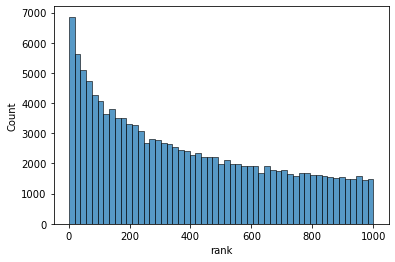

In [16]:
sns.histplot(data=metadata_parsed[metadata_parsed['rank'] <= 1000], x="rank")

<AxesSubplot:xlabel='rank', ylabel='Count'>

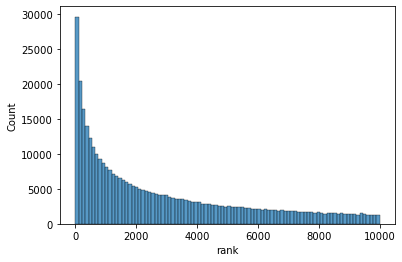

In [17]:
sns.histplot(data=metadata_parsed[metadata_parsed['rank'] <= 10000], x="rank")

### Модели ранжирования в TF Ranking подразумевают, что чем больше скор, тем лучше, поэтому нужна функция, которая адекватно переводит ранги из отсортированных по возрастанию в отсортированные по убыванию, в идеале - ещё в небольшом диапавзоне, чтобы не было nan

In [18]:
metadata_parsed['rank_scaled'] = np.log10(metadata_parsed['rank'])

In [19]:
metadata_parsed

,category,description,title,brand,price,feature,rank,category_id,rank_scaled
0,Beauty & Personal Care (See Top 100 in Beauty ...,"[""These extra long backscratcher/shoehorns are...",BambooMN Brand - 1 x 25 Bamboo Backscratcher S...,BambooMN,9.95,"[""A perfect gift for a friend who could use an...",175420,0,5.244079
1,Beauty & Personal Care (See Top 100 in Beauty ...,[],Infinity Jars 30 Ml (1 fl oz) Black Ultraviole...,Infinity Jars,13.00,"LABORATORY TESTED AND APPROVED, ULTRAVIOLET GL...",132516,0,5.122268
2,Beauty & Personal Care (See Top 100 in Beauty ...,Bring a natural element into your bathroom or ...,InterDesign Twigz Free Standing Toilet Paper H...,InterDesign,24.37,VINTAGE LOOK: Silver finish steel wire toilet ...,41845,0,4.621644
3,Grocery & Gourmet Food (See Top 100 in Grocery...,"["". Simply heat bottle in a hot water bath unt...",F/X Gelatin-Graftobian,Graftobian,29.99,"[""F/X Gelatin is the ''heat and serve'' of gor...",302442,1,5.480642
4,Beauty & Personal Care (See Top 100 in Beauty ...,BOOK LOVER Street Sign books novels readers re...,SignMission Book Lover Street Sign Books Novel...,SignMission,8.99,"Sign Size: 4"" X 18""', 'Perfect Gift - Good for...",250013,0,5.397963
...,...,...,...,...,...,...,...,...,...
917608,Camera & Photo > Camera & Photo Accessories > ...,Key Features: 1. Compliable with most telesco...,Ueasy Smartphone Capturer Universal Cell Phone...,Ueasy,12.99,"Compliable with most telescope, binocular, mon...",832,1188,2.920123
917609,Health & Household (See Top 100 in Health & Ho...,[],Geilienergy BT-17333 BT-27333 Handset Telephon...,GEILIENERGY,4.98,"Low power consumption IC design.', 'Compatible...",55256,29,4.742379
917610,Electronics > Accessories & Supplies > Telepho...,[],Geilienergy BT-17333 BT-27333 Handset Telephon...,GEILIENERGY,4.98,"Low power consumption IC design.', 'Compatible...",118,1218,2.071882
917611,Computers & Accessories > Computer Accessories...,1.M.2 NGFF (SATA) SSD to 2.5 SATA Adapter Conv...,M.2 NGFF (SATA) SSD to 2.5 SATA Adapter SATA H...,TSK,9.99,M.2 NGFF (SATA) SSD to 2.5 SATA Adapter Conver...,1295,1053,3.112270


In [20]:
metadata_parsed['rank_scaled'].describe()

count    849052.000000
mean          4.138569
std           1.097620
min           0.000000
25%           3.385249
50%           4.191954
75%           5.000074
max           5.999997
Name: rank_scaled, dtype: float64

In [21]:
metadata_parsed['rank_scaled'] = -metadata_parsed['rank_scaled'] + metadata_parsed['rank_scaled'].max() 

In [22]:
metadata_parsed['rank_scaled'].describe()

count    849052.000000
mean          1.861427
std           1.097620
min           0.000000
25%           0.999923
50%           1.808043
75%           2.614748
max           5.999997
Name: rank_scaled, dtype: float64

In [23]:
metadata_parsed

,category,description,title,brand,price,feature,rank,category_id,rank_scaled
0,Beauty & Personal Care (See Top 100 in Beauty ...,"[""These extra long backscratcher/shoehorns are...",BambooMN Brand - 1 x 25 Bamboo Backscratcher S...,BambooMN,9.95,"[""A perfect gift for a friend who could use an...",175420,0,0.755917
1,Beauty & Personal Care (See Top 100 in Beauty ...,[],Infinity Jars 30 Ml (1 fl oz) Black Ultraviole...,Infinity Jars,13.00,"LABORATORY TESTED AND APPROVED, ULTRAVIOLET GL...",132516,0,0.877728
2,Beauty & Personal Care (See Top 100 in Beauty ...,Bring a natural element into your bathroom or ...,InterDesign Twigz Free Standing Toilet Paper H...,InterDesign,24.37,VINTAGE LOOK: Silver finish steel wire toilet ...,41845,0,1.378353
3,Grocery & Gourmet Food (See Top 100 in Grocery...,"["". Simply heat bottle in a hot water bath unt...",F/X Gelatin-Graftobian,Graftobian,29.99,"[""F/X Gelatin is the ''heat and serve'' of gor...",302442,1,0.519354
4,Beauty & Personal Care (See Top 100 in Beauty ...,BOOK LOVER Street Sign books novels readers re...,SignMission Book Lover Street Sign Books Novel...,SignMission,8.99,"Sign Size: 4"" X 18""', 'Perfect Gift - Good for...",250013,0,0.602034
...,...,...,...,...,...,...,...,...,...
917608,Camera & Photo > Camera & Photo Accessories > ...,Key Features: 1. Compliable with most telesco...,Ueasy Smartphone Capturer Universal Cell Phone...,Ueasy,12.99,"Compliable with most telescope, binocular, mon...",832,1188,3.079873
917609,Health & Household (See Top 100 in Health & Ho...,[],Geilienergy BT-17333 BT-27333 Handset Telephon...,GEILIENERGY,4.98,"Low power consumption IC design.', 'Compatible...",55256,29,1.257617
917610,Electronics > Accessories & Supplies > Telepho...,[],Geilienergy BT-17333 BT-27333 Handset Telephon...,GEILIENERGY,4.98,"Low power consumption IC design.', 'Compatible...",118,1218,3.928115
917611,Computers & Accessories > Computer Accessories...,1.M.2 NGFF (SATA) SSD to 2.5 SATA Adapter Conv...,M.2 NGFF (SATA) SSD to 2.5 SATA Adapter SATA H...,TSK,9.99,M.2 NGFF (SATA) SSD to 2.5 SATA Adapter Conver...,1295,1053,2.887727


In [24]:
df = metadata_parsed.groupby('category_id')['title'].count() > 40

In [25]:
df = df.reset_index()

In [26]:
category_ids = list(df[df['title'] == True].category_id)

In [28]:
metadata_parsed = metadata_parsed[metadata_parsed['category_id'].isin(category_ids)]

### Посчитаем NDCG рандомного предсказания

Для начала нужно понять, что такое рандомное предсказание. По-хорошему BERT будет предсказывать новые ранги, а не просто сортировать уже имеющиеся. В качестве довольно плохого приближения можно исплользовать равномерное распределение на [0, 6]
А есть нормальная идея: взять весь список рангов и выбирать из него рандомные

In [29]:
all_ranks = list(metadata_parsed["rank_scaled"])

In [30]:
len(all_ranks)

834683

In [31]:
list(metadata_parsed[metadata_parsed['category_id'] == category_ids[0]].sort_values(by='rank').iloc[0:40]['rank_scaled'])[0:10]

[3.031513577076312,
 2.8005156107678912,
 1.8673206765372852,
 1.8519494320309118,
 1.6795801881740777,
 1.5972022769893446,
 1.4948058341110642,
 1.4446118379130999,
 1.378352953435674,
 1.3256314800116975]

In [32]:
import random

NUM_ITEMS = 40

real_ranks = []
random_ranks = []

for category in category_ids:
    real_ranks.append(list(metadata_parsed[metadata_parsed['category_id'] == category].sort_values(by='rank').iloc[0:NUM_ITEMS]['rank_scaled']))
    random_ranks.append(random.sample(all_ranks, NUM_ITEMS))

In [33]:
print(np.array(real_ranks).shape)
print(np.array(random_ranks).shape)

(1181, 40)
(1181, 40)


In [44]:
for i in range(1, 41):
    ndcg = tfr.keras.metrics.NDCGMetric(topn=i)
    print(f"NDCG@{i}: {ndcg(real_ranks, random_ranks).numpy()}")

NDCG@1: 0.4023810625076294
NDCG@2: 0.4354186952114105
NDCG@3: 0.46190279722213745
NDCG@4: 0.4863879084587097
NDCG@5: 0.505688488483429
NDCG@6: 0.5230868458747864
NDCG@7: 0.5389911532402039
NDCG@8: 0.552715539932251
NDCG@9: 0.566389262676239
NDCG@10: 0.5799574255943298
NDCG@11: 0.5926433801651001
NDCG@12: 0.6051404476165771
NDCG@13: 0.6167564392089844
NDCG@14: 0.6270198822021484
NDCG@15: 0.6375774145126343
NDCG@16: 0.6475955247879028
NDCG@17: 0.656817615032196
NDCG@18: 0.6660481691360474
NDCG@19: 0.6754860281944275
NDCG@20: 0.6845948100090027
NDCG@21: 0.6931846737861633
NDCG@22: 0.7019683122634888
NDCG@23: 0.7100473046302795
NDCG@24: 0.7183712124824524
NDCG@25: 0.7264122366905212
NDCG@26: 0.7339683771133423
NDCG@27: 0.7415992617607117
NDCG@28: 0.7491804361343384
NDCG@29: 0.7564801573753357
NDCG@30: 0.7632758617401123
NDCG@31: 0.7704277038574219
NDCG@32: 0.7771943807601929
NDCG@33: 0.7838699221611023
NDCG@34: 0.7911373972892761
NDCG@35: 0.7975350618362427
NDCG@36: 0.8039128184318542
NDCG

### Хочу в принципе посмотреть на поведение метрики NDCG, чтобы понимать, что происходит

In [45]:
y_true = [[0., 1., 1.]]
y_pred = [[1., 2., 3.]]
ndcg = tfr.keras.metrics.NDCGMetric()
ndcg(y_true, y_pred).numpy()

1.0

In [47]:
y_true = [[0., 1., 100.]]
y_pred = [[1., 2., 300.]]
ndcg = tfr.keras.metrics.NDCGMetric()
ndcg(y_true, y_pred).numpy()

1.0

In [48]:
y_true = [[0., 1., 4., 2.]]
y_pred = [[1., 2., 300., 3.]]
ndcg = tfr.keras.metrics.NDCGMetric()
ndcg(y_true, y_pred).numpy()

1.0

In [49]:
y_true = [[0., 1., 4., 2.]]
y_pred = [[1., 2., 300., 1.]]
ndcg = tfr.keras.metrics.NDCGMetric()
ndcg(y_true, y_pred).numpy()

0.98494434

In [50]:
y_true = [[0., 2., 4., 1.]]
y_pred = [[1., 1., 300., 2.]]
ndcg = tfr.keras.metrics.NDCGMetric()
ndcg(y_true, y_pred).numpy()

0.98494434

In [52]:
y_true = [[0., 3., 4., 1.]]
y_pred = [[1., 1., 300., 2.]]
ndcg = tfr.keras.metrics.NDCGMetric()
ndcg(y_true, y_pred).numpy()

0.96055645

In [58]:
y_true = [[0., 3., 4., 1.]]
y_pred = [[1., 1., 2.5, 2.]]
ndcg = tfr.keras.metrics.NDCGMetric()
ndcg(y_true, y_pred).numpy()

0.93619156

In [59]:
y_true = [[0., 3., 4., 1.]]
y_pred = [[1., 1., 3., 2.]]
ndcg = tfr.keras.metrics.NDCGMetric()
ndcg(y_true, y_pred).numpy()

0.96055645

__Вывод__: на вход можно подавать не в отсортированном порядке 

Подмешиваем какой-то процент рандомных рангов в настоящие. При этом хорошо бы настоящие ранги заменить на другие, но тоже отсортированные 

In [39]:
import random
percentage = [0., 10., 20., 25., 30., 50., 100.]

for p in percentage:
    target_ranks = []
    predicted_ranks = []
    for i, (real, rand) in enumerate(zip(real_ranks, random_ranks)): 
        for i in range(10):  
            nice = [] 
            for g, b in zip(real_ranks[(i + 1) // len(real_ranks)], rand):
                n = random.random()    
                if n >= p / 100.:
                    nice.append(g)
                else:
                    nice.append(b) 
            predicted_ranks.append(nice)
            target_ranks.append(real)

    ndcg = tfr.keras.metrics.NDCGMetric()
    print(f"Percentage: {p}")
    for i in [3, 5, 10, 20, 40]:
        ndcg = tfr.keras.metrics.NDCGMetric(topn=i)
        print(f"NDCG@{i}: {ndcg(target_ranks, predicted_ranks).numpy()}")

Percentage: 0.0
NDCG@3: 1.0
NDCG@5: 1.0
NDCG@10: 1.0
NDCG@20: 1.0
NDCG@40: 1.0
Percentage: 10.0
NDCG@3: 0.8211092948913574
NDCG@5: 0.847979724407196
NDCG@10: 0.8984596729278564
NDCG@20: 0.9311524033546448
NDCG@40: 0.9522101283073425
Percentage: 20.0
NDCG@3: 0.7059953808784485
NDCG@5: 0.7436279654502869
NDCG@10: 0.8176823258399963
NDCG@20: 0.8791712522506714
NDCG@40: 0.9179748892784119
Percentage: 25.0
NDCG@3: 0.6630180478096008
NDCG@5: 0.7076815366744995
NDCG@10: 0.7847868204116821
NDCG@20: 0.8585457801818848
NDCG@40: 0.9053007960319519
Percentage: 30.0
NDCG@3: 0.627774715423584
NDCG@5: 0.677333652973175
NDCG@10: 0.7556678056716919
NDCG@20: 0.8400372266769409
NDCG@40: 0.8945969343185425
Percentage: 50.0
NDCG@3: 0.5251226425170898
NDCG@5: 0.5896186232566833
NDCG@10: 0.6685792207717896
NDCG@20: 0.778605580329895
NDCG@40: 0.8628160357475281
Percentage: 100.0
NDCG@3: 0.46151524782180786
NDCG@5: 0.5051537752151489
NDCG@10: 0.5809990167617798
NDCG@20: 0.6849804520606995
NDCG@40: 0.8293998837

In [40]:
print(np.array(target_ranks).shape)
print(np.array(predicted_ranks).shape)

(11810, 40)
(11810, 40)


Получается, что я стремлюсь всего лишь к 
Percentage: 30.0  
NDCG@3: 0.627774715423584  
NDCG@5: 0.677333652973175  
NDCG@10: 0.7556678056716919  
NDCG@20: 0.8400372266769409  
NDCG@40: 0.8945969343185425  

Сейчас на уровне 50%, что конечно нехорошо, но и не ужасно

In [45]:
predicted_ranks[1]

[0.7720789846333389,
 3.382996184509348,
 4.1870831689873915,
 1.7780869790421132,
 1.150190289071654,
 2.989696568990435,
 2.801614395621953,
 0.4388498059126693,
 1.3799958833301798,
 0.4910307112279524,
 0.5939829270325374,
 3.2358203932399165,
 1.2047632197479867,
 0.03317360243420531,
 2.1752850821655128,
 1.0991216512977564,
 1.1450835033223914,
 3.6903663582043484,
 2.888062249297566,
 0.5750724412370838,
 2.566386682306529,
 0.8493567317535797,
 2.5996312522803082,
 1.2186720699632598,
 2.1665943963983887,
 1.1532451135937851,
 2.074426616086871,
 4.229144513988103,
 1.5816455087815386,
 2.9926755727075025,
 1.1355981859140032,
 2.2428283334159747,
 3.44369402486296,
 2.4597922257881875,
 2.4701813289856167,
 2.2714804208704806,
 1.1731575188391759,
 1.4012388383299914,
 1.3850044498038212,
 0.6869586292679895]

In [27]:
from sklearn.model_selection import GroupShuffleSplit

In [28]:
gss = GroupShuffleSplit(test_size=.33, n_splits=1, random_state = 7).split(metadata_parsed, groups=metadata_parsed['category_id'])

X_train_inds, X_test_inds = next(gss)

train_data = metadata_parsed.iloc[X_train_inds]
test_data = metadata_parsed.iloc[X_test_inds]

In [63]:
train_data.to_csv('train.csv', index=False)

In [64]:
test_data.to_csv('test.csv', index=False)

In [3]:
test_data = pd.read_csv('test.csv')

In [16]:
len(set(test_data.category_id))

897

In [35]:
eval_categories = []

for i in range(96):
    eval_categories.append(test_data[test_data['category_id'] == i].sort_values(by='rank').iloc[0:23].sample(frac=1))    
eval_data = pd.concat(eval_categories)

In [36]:
len(set(eval_data.category_id))

30

In [37]:
eval_data.to_csv('eval.csv', index=False)